In [1]:
import commonsetting
from models import perceptual_network, Encoder, Class_out, Conf_out
from dataloader import CustomImageDataset, concatenate_transform_steps
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch import nn
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd


def calculate_confidence_label(y_pred):
    if y_pred <= 1/3:
        y_pred = 0
    elif y_pred >= 2/3:
        y_pred = 1
    else:
        y_pred = 0.5

    return y_pred


if __name__ == "__main__":
    pretrained_model_name   = commonsetting.pretrained_model_name
    hidden_layer_size       = commonsetting.hidden_layer_size
    hidden_activation_name  = commonsetting.hidden_activation_name
    hidden_activation       = commonsetting.hidden_activation
    hidden_dropout          = commonsetting.hidden_dropout
    resize                  = commonsetting.image_resize
    in_shape                = (1,3,resize,resize)

    SimpleCNN_args = dict(
        pretrained_model_name   = pretrained_model_name,
        hidden_layer_size       = hidden_layer_size,
        hidden_activation       = hidden_activation,
        hidden_dropout          = hidden_dropout,
        hidden_layer_type       = commonsetting.hidden_layer_type,
        output_layer_size       = commonsetting.output_layer_size,
        in_shape                = (1,3,resize,resize),
        retrain_encoder         = commonsetting.retrain_encoder,
        device                  = commonsetting.device,
        )
        

    tranformer_steps = concatenate_transform_steps(image_resize=commonsetting.image_resize, rotate=0)

    dataset_val = CustomImageDataset(commonsetting.val_dir,label_map=commonsetting.label_map , transform=tranformer_steps)
    dataloader_test = DataLoader(dataset_val, batch_size=commonsetting.batch_size, shuffle=True, num_workers=commonsetting.num_workers)
    SimpleCNN = perceptual_network(**SimpleCNN_args)
    SimpleCNN.load_state_dict(torch.load("../models/train_pixel_0.6/simplecnn_bs32e4i224h300.h5"))
    for p in SimpleCNN.parameters(): p.requires_grad = False
    # define loss function
    classification_loss = nn.BCELoss()
    # when there is no noise
    SimpleCNN.eval()
    SimpleCNN.to(commonsetting.device)
    with torch.no_grad():
        # extract features of each image
        y_true = []
        y_pred = []
        y_correct_pred = []
        confidence_out = []
        for idx_batch, (batch_image, batch_label) in tqdm(enumerate(dataloader_test)):
            batch_label = torch.vstack(batch_label).T.float()
            #记得每一次处理数据之前要做这一步
                        #记得每一次处理数据之前要做这一步
            batch_image = batch_image.to(commonsetting.device)
            batch_label = batch_label.to(commonsetting.device)
            
            features,hidden_representation,prediction, confidence =  SimpleCNN(batch_image.to(commonsetting.device))
            correct_preds = batch_label.clone().detach().argmax(1)==prediction.clone().detach().argmax(1)
            correct_preds = correct_preds.float()

            correct_preds = torch.vstack([1-correct_preds, correct_preds]).T.float()
            
            
            y_correct_pred.append(correct_preds.detach().cpu().numpy())
            y_true.append(batch_label.detach().cpu().numpy())
            y_pred.append(prediction.detach().cpu().numpy())
            confidence_out.append(confidence.detach().cpu().numpy())
    
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_correct_pred = np.concatenate(y_correct_pred, axis=0)
    confidence_out = np.concatenate(confidence_out, axis=0)


/root/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
24it [00:04,  5.79it/s]


In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [3]:
roc_auc_score(y_true, y_pred)

0.5951613333333333

In [4]:
roc_auc_score(y_correct_pred, confidence_out)

0.5225770925110131

In [5]:
y_pred.shape

(1500, 3)

In [6]:
y_pred

array([[0.30789876, 0.2537117 , 0.4383895 ],
       [0.2724275 , 0.27102768, 0.45654476],
       [0.29015812, 0.22117834, 0.48866358],
       ...,
       [0.31340897, 0.32986903, 0.35672197],
       [0.2821898 , 0.3276967 , 0.39011353],
       [0.21402913, 0.14170633, 0.6442645 ]], dtype=float32)

In [7]:
y_true

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [8]:
from matplotlib import pyplot as plt

(array([  6.,  48., 181., 326., 365., 290., 158.,  86.,  34.,   6.]),
 array([0.34344915, 0.37618244, 0.40891573, 0.44164902, 0.47438231,
        0.5071156 , 0.53984892, 0.57258219, 0.60531551, 0.63804877,
        0.67078209]),
 <BarContainer object of 10 artists>)

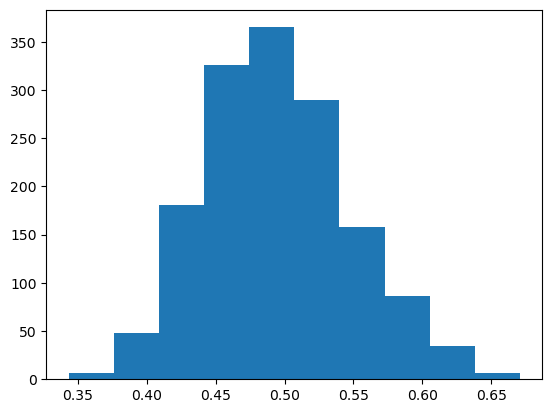

In [9]:
plt.hist(confidence_out[:,1])

In [10]:
from collections import Counter
Counter(y_correct_pred[:,1])

Counter({0.0: 908, 1.0: 592})

In [11]:
def type2_correct(confidence, correct_trial):
    confidence_onehot = np.vstack([1-confidence.argmax(1), confidence.argmax(1)]).T
    idx_correct_trial = correct_trial == 1#正确的trial
    total_correct = sum(idx_correct_trial.astype(int))
    type2_acc =confidence_onehot[:, 1][idx_correct_trial]
    return  sum(type2_acc), total_correct

In [12]:
type2_correct, total_correct = type2_correct(confidence_out, y_correct_pred[:,1])

In [13]:
type2_correct/total_correct

0.46452702702702703